This notebook performs backtest Machine Learning models on the MVP data.

In [34]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV as gcv
import xgboost as xgb

# Set working path
path = '/Users/martinbogaert/Desktop/NBA Data Analysis/2022-2023 Awards Project clean/'

In [5]:
data = pd.read_csv(path + 'Machine Learning/mvp/mvp_data.csv')

# Correlation, feature analysis

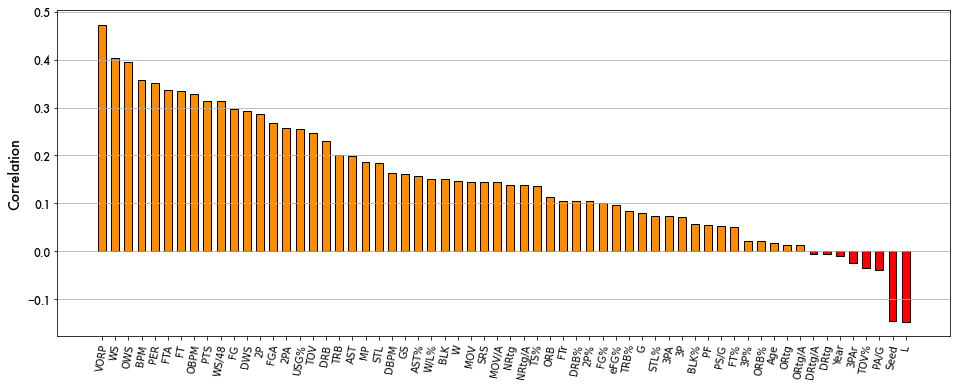

In [6]:
corr_df = data.corr().sort_values('Share', ascending = False)

plt.figure(figsize = (16, 6))

plt.bar(corr_df[corr_df['Share'] >= 0].index[1:], corr_df[corr_df['Share'] >= 0]['Share'][1:],
                        width = 0.6, color = 'darkorange', edgecolor = 'black')
plt.bar(corr_df[corr_df['Share'] < 0].index, corr_df[corr_df['Share'] < 0]['Share'],
                        width = 0.6, color = 'red', edgecolor = 'black')

#plt.plot(range(1, len(corr_df)), corr_df['Share'][1:], alpha = 0.5, linestyle = '-', c = 'black')
plt.xticks(rotation = 80)
plt.yticks(fontname = 'futura', size = 11)
plt.ylabel('Correlation', fontname = 'futura', size = 14)
plt.grid(axis = 'y')
plt.show()

In [7]:
features = ['VORP','WS','OWS','BPM','PER','PTS','FT','FTA','OBPM','FG','USG%','Seed','MP','GS']

# Finding the optimal model

In [65]:
X_train = data[data['Year'] < 2022]
X_test = data[data['Year'] == 2022]

params_grid = {'n_estimators' : [70, 75, 80]
}


grid = gcv(xgb.XGBRegressor(colsample_bytree = 0.9, colsample_bylevel = 0.1), params_grid, cv = 10, verbose = 1, scoring = 'neg_mean_squared_error')

grid.fit(data[features], data['Share'])

print(grid.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
{'n_estimators': 70}


In [44]:
def score_model_year(model, year, features):
    
    #####
    # Function returns the (1) mean squared error of the shares, (2) r2-score of the shares, (3) accuracy of MVP prediction
    # (4) mean absolute error of the rank of vote getters and (5) mean absolute error of the rank of the top 3
    
    # Split train / test
    X_train = data[data['Year'] < year]
    X_test = data[data['Year'] == year]
    
    # Fit model and predict
    model.fit(X_train[features], X_train['Share'])
    pred = model.predict(X_test[features])
    
    # Assemble results DataFrame
    res = X_test.assign(pred = pred)
    res['Rank'] = [len(res[res['Share'] > share])+1 for share in res['Share']] # Add rank
    res['Pred. rank'] = [len(res[res['pred'] > share])+1 for share in res['pred']] # Add predicted rank
    
    # Calculate mse, r2 scores
    mse = mean_squared_error(res['pred'], res['Share'])
    r2 = r2_score(res['pred'], res['Share'])
    
    # Calulate accuracy
    acc = list(res.sort_values('Share').tail(1)['Player'])[0] == list(res.sort_values('pred').tail(1)['Player'])[0]
    
    # Calculate top 3 and vote getters mae
    vote_getters = res[res['Share'] > 0] # Players which received votes
    top3 = res.sort_values('Share').tail(3) # Top 3
    mae = mean_absolute_error(vote_getters['Rank'], vote_getters['Pred. rank'])
    mae_3 = mean_absolute_error(top3['Rank'], top3['Pred. rank'])
    
    return 100*mse, r2, acc, mae, mae_3

In [66]:
rf1 = RandomForestRegressor(n_estimators = 80, random_state = 1, max_features = 'auto', min_samples_leaf = 2)
xgreg = xgb.XGBRegressor(n_estimators = 70, colsample_bytree = 0.9, colsample_bylevel = 0.1)

for year in range(2016, 2023):
    print(year)
    for model in [rf1, rf2, xgreg] :
        score = score_model_year(model, year, features)
        print
        print(f'({score[2]}) : mse = {score[0]}, r2 = {score[1]}, mae = {score[3]}, mae (top 3) = {score[-1]}')
    print('\n')

2016
(True) : mse = 0.0005660816905955318, r2 = 0.8736095854929912, mae = 2.7, mae (top 3) = 1.0
(True) : mse = 0.00044955502260394826, r2 = 0.9012193195847156, mae = 2.1, mae (top 3) = 0.6666666666666666
(True) : mse = 0.0010739349387389509, r2 = 0.7982902282406034, mae = 3.9, mae (top 3) = 1.0


2017
(False) : mse = 0.0032634062663700054, r2 = 0.039112304270961684, mae = 4.0, mae (top 3) = 4.0
(False) : mse = 0.00332555473380796, r2 = 0.10814897595538897, mae = 3.909090909090909, mae (top 3) = 3.6666666666666665
(False) : mse = 0.0033001304141908653, r2 = 0.19321964895546406, mae = 3.5454545454545454, mae (top 3) = 3.3333333333333335


2018
(True) : mse = 0.0010134593815048609, r2 = 0.527066749017357, mae = 3.6923076923076925, mae (top 3) = 0.6666666666666666
(True) : mse = 0.0009854368246763317, r2 = 0.5605427570024923, mae = 3.6153846153846154, mae (top 3) = 0.6666666666666666
(True) : mse = 0.000630483792500277, r2 = 0.760594960041086, mae = 30.153846153846153, mae (top 3) = 0.0



# Backtests

In [94]:
features = ['VORP','WS','OWS','BPM','PER','PTS','FT','FTA','OBPM','FG','USG%','Seed','MP','GS']

In [123]:
years = np.arange(1988, 2023)
dfs = []

for year in years:
    
    print(f'Processing {year-1}-{year} season ...')
    clear_output(wait = True)
    
    X_train = data[data['Year'] != year]
    X_test = data[data['Year'] == year]
    
    model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
    model.fit(X_train[features], X_train['Share'])
    
    # Predict shares of test data
    pred = model.predict(X_test[features])
    X_test = X_test.assign(pred = pred)
    mse = mean_squared_error(pred, X_test['Share'])
    r2 = r2_score(pred, X_test['Share'])
    
    X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
    X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank
    
    X_pred = X_test.sort_values('pred').tail(1)[['Year', 'Player', 'pred', 'Rank']].rename(columns = {'Player' : 'Pred. MVP'})
    X_test = X_test.sort_values('Share').tail(1)[['Year', 'Player', 'Tm', 'Share','pred', 'Pred. rank']].rename(columns = {'Player' : 'MVP'})
    
    dfs.append(X_test.merge(X_pred, on = 'Year').assign(mse = mse, r2 = r2))

Processing 2021-2022 season ...


In [124]:
res = pd.concat(dfs)
res['correct'] = [True if act == pred else False for act, pred in zip(res['MVP'], res['Pred. MVP'])]
print('Accuracy :', round(100*res['correct'].mean(), 2), '%')
print('Mean squared error :', round(100*res['mse'].mean(), 2))
res.set_index('Year')

Accuracy : 68.57 %
Mean squared error : 0.13


,MVP,Share,pred_x,Pred. rank,Pred. MVP,pred_y,Rank,mse,r2,correct
Year,,,,,,,,,,
1988,Michael Jordan,0.831,0.711025,2,Larry Bird,0.763074,2,0.001174,0.770540,False
1989,Magic Johnson,0.782,0.703373,1,Magic Johnson,0.703373,1,0.000639,0.858659,True
1990,Magic Johnson,0.691,0.727963,2,Michael Jordan,0.832160,3,0.000885,0.859996,False
1991,Michael Jordan,0.928,0.964975,1,Michael Jordan,0.964975,1,0.000324,0.939413,True
1992,Michael Jordan,0.938,0.864913,1,Michael Jordan,0.864913,1,0.000449,0.891036,True
1993,Charles Barkley,0.852,0.544820,2,Michael Jordan,0.720654,3,0.000992,0.745384,False
1994,Hakeem Olajuwon,0.880,0.372562,3,David Robinson,0.690902,2,0.001346,0.607546,False
1995,David Robinson,0.858,0.812030,1,David Robinson,0.812030,1,0.000423,0.890582,True
1996,Michael Jordan,0.986,0.907599,1,Michael Jordan,0.907599,1,0.000427,0.900737,True


In [97]:
X_train = data[data['Year'] < 2022]
X_test = data[data['Year'] == 2022]

model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
model.fit(X_train[features], X_train['Share'])

# Predict shares of test data
pred = model.predict(X_test[features])
X_test = X_test.assign(pred = pred)

X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank

In [98]:
res_2022 = X_test.sort_values('Pred. rank')[['Player','Tm','Share', 'Rank', 'Pred. rank','pred']]

In [99]:
tm_col = {'ATL': '#e03a3e', 'BOS': 'green','BRK': 'gray','CHI': '#ce1141','CHO': 'aqua','CLE': 'maroon','DAL': 'cornflowerblue',
          'DEN': 'indigo','DET': 'royalblue','GSW': 'gold','HOU': 'lightcoral','IND': 'yellow','LAC': 'silver','LAL': '#fdb927','MEM': 'skyblue','MIA': 'hotpink',
          'MIL': '#00471b','MIN': 'lime','NOP': 'goldenrod','NYK': 'darkorange','OKC': 'dodgerblue','ORL': 'navy',
          'PHI': 'blue','PHO': 'orange','POR': '#cf0a2c','SAC': 'mediumslateblue','SAS': 'white','TOR': 'purple',
          'UTA': 'forestgreen','WAS': 'midnightblue'}

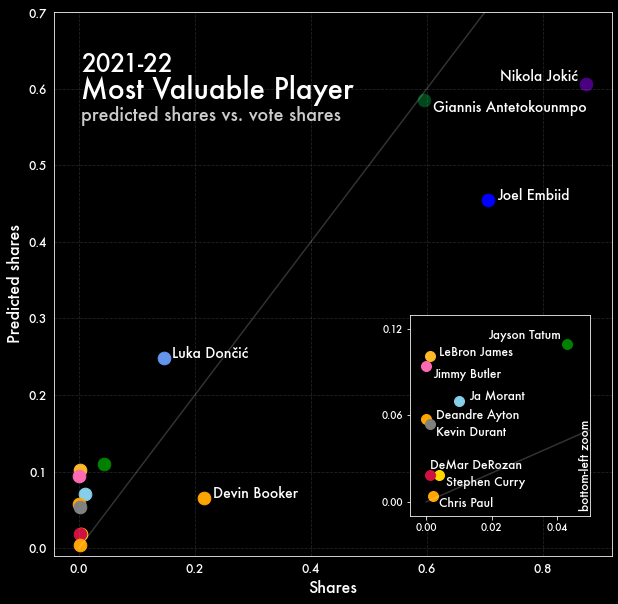

In [406]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = 'black')

plt.plot([0, max(res_2022['Share'].max(), res_2022['pred'].max())], [0, max(res_2022['Share'].max(), res_2022['pred'].max())], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if pred > 0.05 or share > 0:
        plt.scatter(share, pred, c = tm_col.get(tm), s = 160)
        
        if player == 'Nikola Jokić':
            plt.annotate(player, xy = (share - 0.015, pred), fontname = 'futura', color = 'white', size = 14, va = 'bottom', ha = 'right')
            
        elif player == 'Giannis Antetokounmpo':
            plt.annotate(player, xy = (share + 0.015, pred), fontname = 'futura', color = 'white', size = 14, va = 'top', ha = 'left')

        elif pred > 0.2 or share > 0.2 :
            plt.annotate(player, xy = (share + 0.015, pred - 0.005), fontname = 'futura', color = 'white', size = 14, va = 'bottom')
      
plt.ylabel('Predicted shares', color = 'white', size = 16, fontname = 'futura')
plt.xlabel('Shares', color = 'white', size = 16, fontname = 'futura')
plt.xticks(color = 'white', fontname = 'futura', size = 12)
plt.yticks(color = 'white', fontname = 'futura', size = 12)
plt.grid(linestyle = '--', alpha = 0.2)

### ANNOTATION ###
# Title
plt.annotate('2021-22', xy = (1/20, 0.89), fontname = 'futura', size = 24, xycoords = 'axes fraction', weight = 'bold', color = 'white') 
plt.annotate('Most Valuable Player', xy = (1/20, 0.84), fontname = 'futura', size = 28, xycoords = 'axes fraction', weight = 'bold', color = 'white')
# Sub-title
plt.annotate('predicted shares vs. vote shares', xy = (1/20, 0.8), fontname = 'futura', size = 18, xycoords = 'axes fraction', color = 'white', alpha = 0.8)
# Signature
#plt.annotate('@      .', xy = (0.875, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = 'white')
#plt.annotate('nba', xy = (0.9, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff9000')
#plt.annotate('ai', xy = (0.95, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff58c4')

ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white'); ax.spines['top'].set_color('white')
ax_gca = plt.gca()
plt.ylim([-0.01,0.7])
ax_gca.set_facecolor('black')

newax = fig.add_axes([0.62,0.18,0.25,0.28], zorder = 1)
newax.plot([0, 0.2], [0, 0.2], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if share < 0.2 and pred < 0.2 :
        if share > 0 or pred > 0.05 :
            newax.scatter(share, pred, c = tm_col.get(tm), s = 100)
            
            if player == 'Chris Paul' or player == 'Stephen Curry' or player == 'Kevin Durant' or player == 'Jimmy Butler' :
                newax.annotate(player, xy = (share+0.002, pred-0.001), fontname = 'futura', color = 'white', size = 12, va = 'top')
            elif player == 'Jayson Tatum' :
                newax.annotate(player, xy = (share-0.002, pred+0.001), fontname = 'futura', color = 'white', size = 12, va = 'bottom', ha = 'right')
            elif player == 'DeMar DeRozan' :
                newax.annotate(player, xy = (share, pred+0.002), fontname = 'futura', color = 'white', size = 12, va = 'bottom')
            else :
                newax.annotate(player, xy = (share+0.003, pred), fontname = 'futura', color = 'white', size = 12)

newax.set_xticks([0, 0.02, 0.04])
newax.set_yticks([0, 0.06, 0.12])
newax.tick_params(colors = 'white')

labels = newax.get_xticklabels() + newax.get_yticklabels()
[label.set_fontname('futura') for label in labels]

newax.annotate('bottom-left zoom', xy = (0.94, 1/25), fontname = 'futura', size = 12, xycoords = 'axes fraction', color = 'white', rotation = 90) 
newax.spines['left'].set_color('white'); newax.spines['right'].set_color('white')
newax.spines['bottom'].set_color('white'); newax.spines['top'].set_color('white')
newax.set_xlim([-0.005, 0.05]); newax.set_ylim([-0.01, 0.13])
ax_gca = plt.gca()
ax_gca.set_facecolor('black')

#plt.savefig(path + 'mvp_2022_test.jpg', dpi = 300)
plt.show()

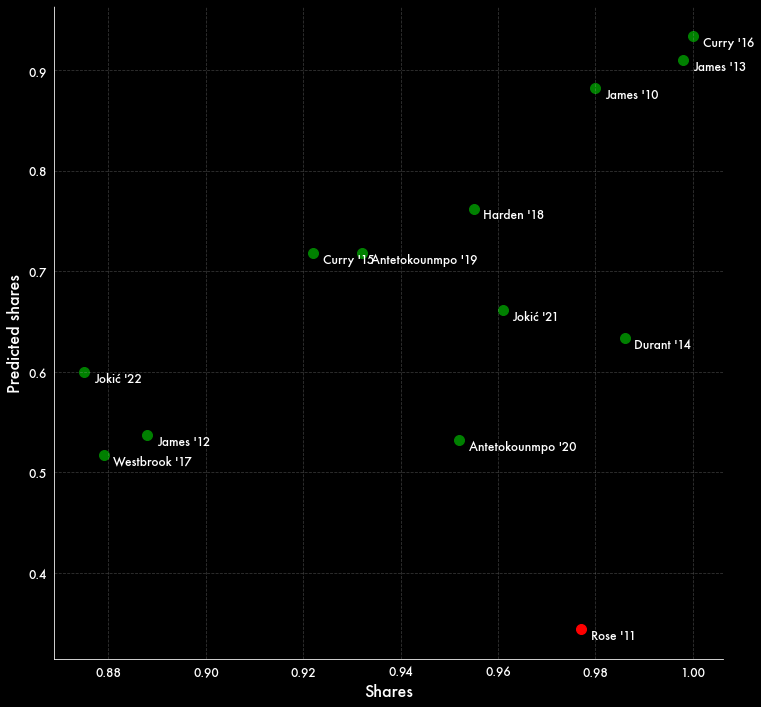

In [389]:
fig, ax = plt.subplots(figsize = (12, 12), facecolor = 'black')

#plt.plot([0, 1], [0, 1], c = 'white', alpha = 0.2)

for player, share, pred, cor, year in zip(res['MVP'], res['Share'], res['pred_x'], res['correct'], res['Year']) :
    
        if cor:
            col = 'green'
        else:
            col = 'red'
        
        if year > 2009 :
            plt.scatter(share, pred, c = col, s = 100)
            label = f"{player.split()[-1]} '{str(year)[-2:]}"
            plt.annotate(label, xy = (share + 0.002, pred), fontname = 'futura', color = 'white', size = 12, va = 'top')
      
plt.ylabel('Predicted shares', color = 'white', size = 16, fontname = 'futura')
plt.xlabel('Shares', color = 'white', size = 16, fontname = 'futura')
plt.xticks(color = 'white', fontname = 'futura', size = 12)
plt.yticks(color = 'white', fontname = 'futura', size = 12)
plt.grid(linestyle = '--', alpha = 0.3)

ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax_gca = plt.gca()
#plt.xlim([0.65,1.05])
ax_gca.set_facecolor('black')


plt.show()